In [0]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

# Data Pre-Processing

While time constraints prevented us from being able to prepare the entire CBIS-DDSM dataset for training and testing our models, we were interested in determining the degree to which the models trained on just the regions of interest would generalize to the entire image, both with respect to identifying the location of the abnormality itself (a segmentation problem) and accurately classifying that abnormality (a classification problem). Furthermore, we were interested in comparing the model's performance -- both with respect to its classifications and using saliency maps -- on the same image, with and without the ROI occluded. This CNN-interpretability technique, outlined in Zeiler and Fergus, *Visualizing and Understanding Convolutional Networks* (2013), would require access to the full images in addition to just the image patches within the ROI. 

<br>

Four mass and four calcification images were each randomly selected from the original CBIS-DDSM dataset, with two malignant and two benign cases for each type of abnormality. The cases were purposefully balanced to include one low-subtlety (5) and one moderate-subtlety (3) case for each subcategory.

**Masses:**

| patient_id | density | image view | mass shape | mass margins | assessment | pathology | subtlety |
| ----------- | ----------- | ----------- | ----------- | ----------- | ----------- | ----------- | ----------- |  
| P_00016 | 4 | CC | IRREGULAR | SPICULATED | 5 | MALIGNANT | 5 |
| P_00324 | 3 | MLO | IRREGULAR | SPICULATED | 4 | MALIGNANT | 3 |
| P_00173 | 2 | CC | LOBULATED | CIRCUMSCRIBED | 3 | BENIGN | 5 |
| P_00177 | 1 | MLO | IRREGULAR | ILL_DEFINED-SPICULATED | 4 | BENIGN | 3 |


**Calcifications:**

| patient_id | density |image view | mass shape | mass margins  |  assessment | pathology  | subtlety |
| -- | -- | -- | -- | -- | -- | -- | -- | 
| P_00390 | 2 | CC  | PLEOMORPHIC  | CLUSTERED  | 5 |  MALIGNANT |  5 |
| P_00497 | 3 | CC  | PLEOMORPHIC  | SEGMENTAL  | 4 |  MALIGNANT |  3 |
| P_00344 | 4 | CC  | PLEOMORPHIC  | CLUSTERED  | 4 |  BENIGN | 5 |
| P_00325 | 4 | MLO | PLEOMORPHIC  | CLUSTERED  | 4 |  BENIGN | 3 |



After converting the DICOM files into PNGs for these images and their associated regions of interest (ROI) using the pydicom library, the images needed significant processing to get into a form that could be fed into the trained models, as performed below:

### Read in full-sized calcification and mass files

In [0]:
calc_files = np.sort([f for f in os.listdir("calcification") if not f.startswith('.')])
mass_files = np.sort([f for f in os.listdir("mass") if not f.startswith('.')])

calc_info_df = pd.read_csv("calc_case_description_test_set.csv", index_col=False)
mass_info_df = pd.read_csv("calc_case_description_test_set.csv", index_col=False)

In [0]:
# read in calcification and mass files
calc_files_table = {} # maps ID to filenames of 3 associated files: {full, roi, crop}

for filename in calc_files:
    uid = filename[12:].split("_")[0]
    if uid not in calc_files_table:
        calc_files_table[uid] = {}
        
    if filename.endswith("full.png"): calc_files_table[uid]['full'] = filename
    elif filename.endswith("clip.png"): calc_files_table[uid]['clip'] = filename
    else: calc_files_table[uid]['roi'] = filename


mass_files_table = {}

for filename in mass_files:
    uid = filename[12:].split("_")[0]
    if uid not in mass_files_table:
        mass_files_table[uid] = {}
        
    if filename.endswith("full.png"): mass_files_table[uid]['full'] = filename
    elif filename.endswith("clip.png"): mass_files_table[uid]['clip'] = filename
    else: mass_files_table[uid]['roi'] = filename

### Process full-sized images to be 299x299

Each image in the original dataset was of different dimensions. They were therefore cropped in a way that ensured the ROI and the region surrounding it was included in the cropped output. Furthermore, several of the images contained white "residual" around the border, so all white pixels were set to be black so as to not raise false positives.

In [0]:
def crop_square(full_img_file, roi_file, img=None, roi=None):
    """ Crop square image from the ROI mask and full-sized image files,
        maximizing original content retained by cropping the two files
        to be as high as they are wide (since width is always the smaller
        dimension). Since the location of the "window" in the mask 
        (corresponding to the ROI) differs in each image, need to handle
        3 possible cases:
            1) window is near the top of the image, so crop from the top
               of the image downwards by an amount equal to img_width
            2) window is near the bottom of the image, so crop from the bottom
               up by an amount equal to img_width
            3) window is in the center of the image, so need to define upper
               and lower bounds to the crop box
    """
    if img is None:
        img = Image.open(full_img_file)
    if roi is None:
        roi = Image.open(roi_file)
    
    assert((img.height == roi.height) & (img.width == roi.width))
    h, w = img.height, img.width

    # get top-most and bottom-most coordinates of ROI "window" (where mask==1)
    roi_arr = np.array(roi) / 255
    window_idxs = np.array(np.where(roi_arr==1))
    upper_window_coord = window_idxs[0,0]
    lower_window_coord = window_idxs[0,-1]

    if lower_window_coord < w//2:           # case 1 (ROI at top of image)
        UL_x = 0   # upper-left x coord
        UL_y = 0   # upper-left y coord
        LR_x = w   # lower-right x coord
        LR_y = w   # lower-right y coord

    elif upper_window_coord > (h - w//2):   # case 2 (ROI at bottom of image)
        UL_x = 0
        UL_y = h - w
        LR_x = w
        LR_y = h
        
    else:                                   # case 3 (ROI in middle of image)
        mid_window_coord = np.mean([lower_window_coord, upper_window_coord], 
                                   dtype=np.int)
        UL_x = 0
        UL_y = mid_window_coord - w//2
        LR_x = w
        LR_y = mid_window_coord + w//2        

    
    cropped_img = img.crop((UL_x, UL_y, LR_x, LR_y))
    cropped_roi = roi.crop((UL_x, UL_y, LR_x, LR_y))

    return cropped_img, cropped_roi

In [0]:
calc_imgs = {}    
for uid in list(calc_files_table.keys()):
    img_file = "calcification/" + calc_files_table[uid]['full']
    roi_file = "calcification/" + calc_files_table[uid]['roi']
    calc_imgs[uid] = {}
    
    # crop image to be square
    cropped_img, cropped_roi = crop_square(img_file, roi_file)
    
    # replace white residuals with black
    img_arr = np.array(cropped_img)
    img_arr[img_arr == 255] = 0
    cropped_img = Image.fromarray(img_arr)
    
    # resize image to be 299x299
    calc_imgs[uid]['full'] = cropped_img.resize((299,299))
    calc_imgs[uid]['roi'] = cropped_roi.resize((299,299))

    
mass_imgs = {}    
for uid in list(mass_files_table.keys()):
    img_file = "mass/" + mass_files_table[uid]['full']
    roi_file = "mass/" + mass_files_table[uid]['roi']
    mass_imgs[uid] = {}
    cropped_img, cropped_roi = crop_square(img_file, roi_file)
    
    img_arr = np.array(cropped_img)
    img_arr[img_arr == 255] = 0
    cropped_img = Image.fromarray(img_arr)

    mass_imgs[uid]['full'] = cropped_img.resize((299,299))
    mass_imgs[uid]['roi'] = cropped_roi.resize((299,299))

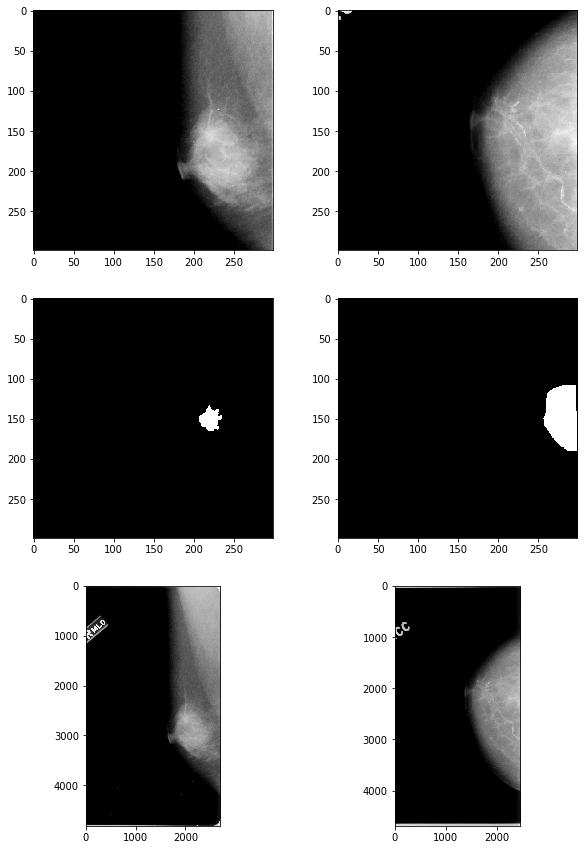

In [0]:
# check results
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(10,15))

axes[0,0].imshow(np.array(mass_imgs['00324']['full']), 'gray')
axes[1,0].imshow(np.array(mass_imgs['00324']['roi']), 'gray')
axes[2,0].imshow(plt.imread("mass/" + mass_files_table['00324']['full']), 'gray')

axes[0,1].imshow(np.array(calc_imgs['00390']['full']), 'gray')
axes[1,1].imshow(np.array(calc_imgs['00390']['roi']), 'gray')
axes[2,1].imshow(plt.imread("calcification/" + calc_files_table['00390']['full']), 'gray');

In [0]:
# save images to PNG

for uid in list(mass_imgs.keys()):
    mass_imgs[uid]['full'].save(f"output_images/mass_full299x299_{uid}.png", "PNG")

for uid in list(calc_imgs.keys()):
    calc_imgs[uid]['full'].save(f"output_images/calc_full299x299_{uid}.png", "PNG")    

### Occluding the ROIs

In [0]:
def occlude_roi(img_file, roi_file, buffer=50):
    """ Black out the bounding box of the ROI defined in roi_file, adding a 
        buffer of the specified number of pixels to each side of the bbox, in 
        the passed image 
    """
    img = Image.open(img_file)
    roi = Image.open(roi_file)

    h, w = img.height, img.width

    # get ROI edges
    roi_arr = np.array(roi) / 255
    window_idxs = np.array(np.where(roi_arr==1))
    upper_window_coord = window_idxs[0,0]
    lower_window_coord = window_idxs[0,-1]

    window_cols = np.where((roi_arr==1).argmax(axis=0) != 0)
    left_window_coord = np.min(window_cols)
    right_window_coord = np.max(window_cols)

    roi_upperlim = max(0, upper_window_coord - buffer)
    roi_lowerlim = min(h-1, lower_window_coord + buffer)
    roi_leftlim = max(0, left_window_coord - buffer)
    roi_rightlim = min(w-1, right_window_coord + buffer)

    mask = np.ones_like(roi_arr)
    mask[roi_upperlim:roi_lowerlim, roi_leftlim:roi_rightlim] = 0

    img_arr = np.array(img) / 255.
    masked_img_arr = np.multiply(mask, img_arr)
    masked_img = Image.fromarray(masked_img_arr)
    
    return masked_img

In [0]:
calc_imgs_masked = {}    
for uid in list(calc_files_table.keys()):
    img_file = "calcification/" + calc_files_table[uid]['full']
    roi_file = "calcification/" + calc_files_table[uid]['roi']
    
    # add mask to image
    img_masked = occlude_roi(img_file, roi_file)
    
    # crop image to be square
    cropped_img_masked, _ = crop_square(None, roi_file, img_masked)
    
    # replace white residuals with black
    img_arr = np.array(cropped_img_masked)
    if np.max(img_arr)>1:
        img_arr[img_arr == 255] = 0
    else:
        img_arr[img_arr == 1] = 0
    cropped_img_masked = Image.fromarray(img_arr)
    
    # resize image to be 299x299
    calc_imgs_masked[uid] = cropped_img_masked.resize((299,299))

    
    
mass_imgs_masked = {}    
for uid in list(mass_files_table.keys()):
    img_file = "mass/" + mass_files_table[uid]['full']
    roi_file = "mass/" + mass_files_table[uid]['roi']   
    
    img_masked = occlude_roi(img_file, roi_file)
    cropped_img_masked, _ = crop_square(None, roi_file, img_masked)
    img_arr = np.array(cropped_img_masked)
    if np.max(img_arr)>1:        
        img_arr[img_arr == 255] = 0
    else:
        img_arr[img_arr == 1] = 0
    cropped_img_masked = Image.fromarray(img_arr)
    
    # resize image to be 299x299
    mass_imgs_masked[uid] = cropped_img_masked.resize((299,299))

    

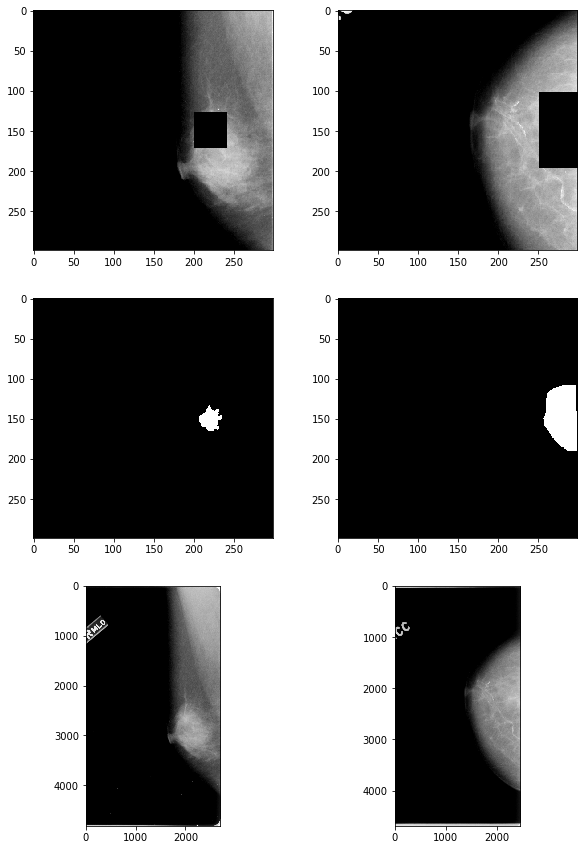

In [0]:
# check results
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(10,15))

axes[0,0].imshow(np.array(mass_imgs_masked['00324']), 'gray')
axes[1,0].imshow(np.array(mass_imgs['00324']['roi']), 'gray')
axes[2,0].imshow(plt.imread("mass/" + mass_files_table['00324']['full']), 'gray')

axes[0,1].imshow(np.array(calc_imgs_masked['00390']), 'gray')
axes[1,1].imshow(np.array(calc_imgs['00390']['roi']), 'gray')
axes[2,1].imshow(plt.imread("calcification/" + calc_files_table['00390']['full']), 'gray');

In [0]:
# save images to PNG

from matplotlib import cm as cm

for uid in list(mass_imgs_masked.keys()):
    img_arr = np.array(mass_imgs_masked[uid])
    img = Image.fromarray(np.uint8(cm.gray(img_arr)*255))
    img.save(f"masked_images/mass_299x299_50buf_mask_{uid}.png", "PNG")

for uid in list(calc_imgs_masked.keys()):
    img_arr = np.array(calc_imgs_masked[uid])
    img = Image.fromarray(np.uint8(cm.gray(img_arr)*255))
    img.save(f"masked_images/calc_299x299_50buf_mask_{uid}.png", "PNG")    

# Analysis: prediction on full images + occluding ROIs

In [0]:
full_img_df = pd.DataFrame({'subtlety': [5,5,5,5,3,3,3,3], 
                            'y': ['1','2','3','4'] * 2, 
                            'filename': ["calc_full299x299_00344.png", "mass_full299x299_00173.png", 
                                         "calc_full299x299_00390.png", "mass_full299x299_00016.png",
                                         "calc_full299x299_00325.png", "mass_full299x299_00177.png",
                                         "calc_full299x299_00497.png", "mass_full299x299_00324.png"]})

masked_img_df = pd.DataFrame({'y': ['1','2','3','4'] * 2, 
                              'filename': ["calc_299x299_50buf_mask_00344.png", "mass_299x299_50buf_mask_00173.png", 
                                           "calc_299x299_50buf_mask_00390.png", "mass_299x299_50buf_mask_00016.png",
                                           "calc_299x299_50buf_mask_00325.png", "mass_299x299_50buf_mask_00177.png",
                                           "calc_299x299_50buf_mask_00497.png", "mass_299x299_50buf_mask_00324.png"]})

full_img_datagen = get_test_datagen(full_img_df, directory='data/CBIS-DDSM_examples/output_images/')
masked_img_datagen = get_test_datagen(masked_img_df, directory='data/CBIS-DDSM_examples/masked_images/')

Found 8 images belonging to 4 classes.
Found 8 images belonging to 4 classes.


In [0]:
y_pred_full_img = model_0.predict_generator(full_img_datagen, full_img_datagen.n)
p_hat_full_img = np.amax(y_pred_full_img, axis=1)
y_hat_full_img = np.argmax(y_pred_full_img, axis=1)

In [0]:
y_pred_masked_img = model_0.predict_generator(masked_img_datagen, masked_img_datagen.n)
p_hat_masked_img = np.amax(y_pred_masked_img, axis=1)
y_hat_masked_img = np.argmax(y_pred_masked_img, axis=1)

In [0]:
pd.DataFrame({"True $y$ (complete image)": ['1','2','3','4'] * 2,
              "$\hat{y}$: complete image": y_hat_full_img,
              "$\hat{p}$: complete image": p_hat_full_img,
              "$\hat{y}$: masked image": y_hat_masked_img,
              "$\hat{p}$: masked image": p_hat_masked_img})

,True $y$ (complete image),$\hat{y}$: complete image,$\hat{p}$: complete image,$\hat{y}$: masked image,$\hat{p}$: masked image
0,1,4,0.688789,4,0.708869
1,2,4,0.712141,4,0.568441
2,3,4,0.641636,4,0.650779
3,4,1,0.265910,0,0.741181
4,1,4,0.515154,4,0.480932
5,2,4,0.484582,4,0.479284
6,3,4,0.459287,0,0.469885
7,4,0,0.393802,0,0.493522


The classifier performed poorly on identifying the particular type and malignancy of the abnormalities in the complete images, though the results on first appearance suggest that the classifier at least identified the presence of an abnormality in the complete images (with the one exception of the final image in which the model egregiously misclassifies an image with a malignant mass as lacking any sort of suspicious abnormality). 

However, even after occluding the region of interest, the classifier continued to identify most of the images as containing a mass, revealing that it would be incorrect to conclude that the classifier had accurately identified the presence of an abnormality in the images. It is possible that there were additional features (e.g. smaller growths) in the image that were not occluded, but which revealed the images to contain an abnormality. To test this, we would have wished to create saliency maps for these images, both with and without the occluded regions of interest. Unfortunately, time did not permit us to do so.